## How to Train a Convolutional Neural Network (CNN) Optimally


In this notebook we conduct the same investigation on CNNs that we performed in the previous notebook in the context of dense DNNs. More specifically, our goal is to determine optimal choices for the following three factors to achieve both effectiveness (high test accuracy) and efficiency (faster convergence) in training CNNs.

- Weight initializer
- Activation function
- Learning rate setting technique


## DNN Architecture 
We create a 4 hidden layer based CNN followed by one dense layer and final output layer.
- In all experiments we train the CNN for 100 fixed epochs. We don't use early stopping for the convenience of comparison.
- We use increasing dropout rate as regularizer for the four hidden layers: 0.2, 0.3, 0.4, 0.5.

## Dataset
We use the CIFAR10 dataset that we used in the previous notebook.


## Experiments

We perform following experiments.

- Experiment 1: Batch Normalization 
 
         -- a) He initializer + ELU activation + NAdam 
         -- b) He initializer + ELU activation + 1cycle Learning Rate Schedule

- Experiment 2: Pretraining based Weight Initialization with 1cycle Learning Rate Schedule
 
         -- a) Orthogonal Initializer 
         -- b) He Initializer

- Experiment 3: Orthogonal Initializer + ELU activation

      -- a) 1cycle Learning Rate Schedule
      -- b) NAdam 

- Experiment 4: He Initializer + ELU activation + 1cycle Learning Rate Schedule

        These experiments are conducted on a GPU from Google Colaboratory.




In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [2]:
# Check whether a GPU is added
tf.test.gpu_device_name()

'/device:GPU:0'

## Load and Scale the Dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train_full[5000:]/255.0
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]/255.0
y_valid = y_train_full[:5000]

X_test = X_test/255.0

print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)

170500096/170498071 [==============================] - 11s 0us/step

Shape of Training Samples:  (45000, 32, 32, 3)
Shape of Training Labels:  (45000, 1)

Shape of Validation Samples:  (5000, 32, 32, 3)
Shape of Validation Labels:  (5000, 1)

Shape of Testing Samples:  (10000, 32, 32, 3)
Shape of Testing Labels:  (10000, 1)

Data type:  float32
Label type:  uint8


## Display a Set of Images

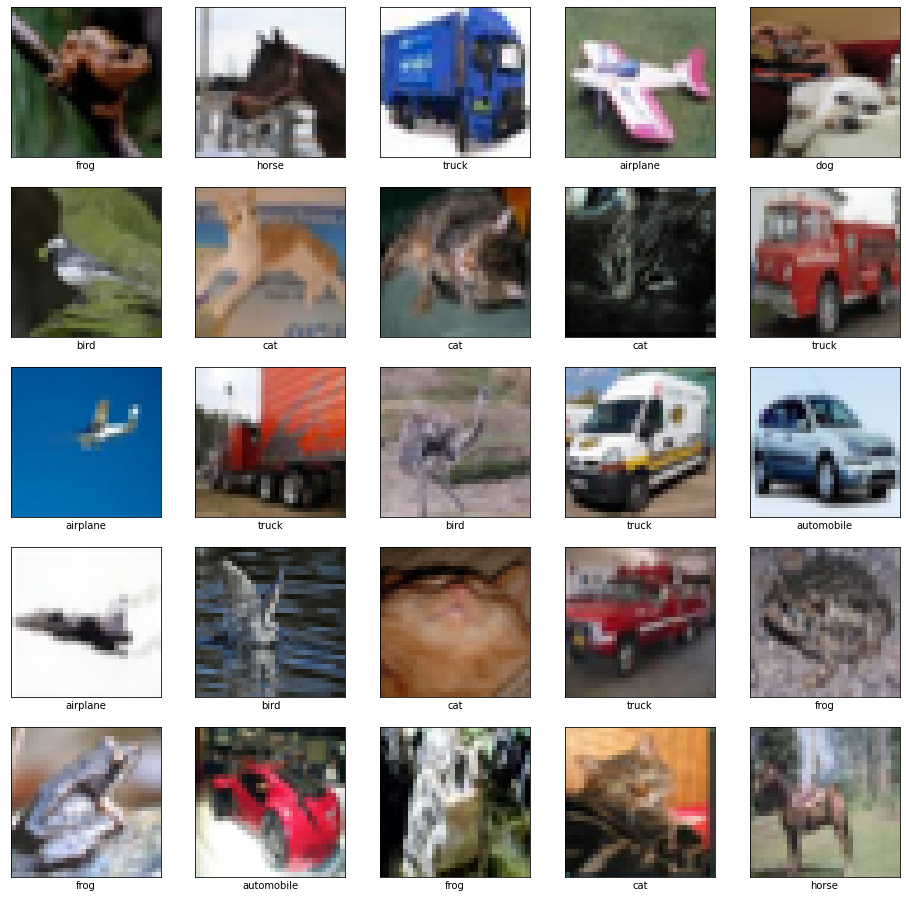

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(16,16))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    # The CIFAR labels are arrays, that's why we use the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## Functions for Various Learning Curves & Converting Training Time

In [5]:
'''
Function For Generating Learning Curves (Accuracy & Loss)
'''
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 
    
    
# Plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

    
'''
Function to Convert Seconds into Hours, Minutes and Seconds
'''
def convertTime(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

## Class to store the Changing Loss and Learning Rates

In [6]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

## Class for 1cycle Learning Schedule

In [7]:
class OneCycle(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, momentum_vals=(0.95, 0.85), start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
        self.step_len =  int(self.iterations * (1 - 10.0/100.0)/2)
        
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        
        # Set Learning Rate
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        
        
        # Set Momentum
        if self.iteration == 0:
            return self.high_mom
        elif self.iteration == self.iterations:
            self.iteration = 0
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        K.set_value(self.model.optimizer.momentum, mom)

        
        
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_OneCycle(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.mom = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.mom.append(K.get_value(self.model.optimizer.momentum))

## Function for Increasing Learning Rate

In [8]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
   

        
'''
Function to determine the "factor" to be used in the IncreaseLearningRate (above) object
'''
def computeFactorForIncreasingLearningRate(X, size_mini_batch, no_of_epochs, upper_bound_lr, lower_bound_lr):
    
    # Total number of iterations
    iterations = len(X) // size_mini_batch * no_of_epochs
    
    factor = np.exp(np.log(upper_bound_lr / lower_bound_lr) / iterations)
    
    return factor

## Experiment 1 (a): Batch Normalization

We use Batch Normalization with the following setting: He initializer + ELU activation + NAdam optimizer 

First, we find the optimal learning rate for the NAdam optimizer.


### Heuristic to Find Optimal Constant Learning Rate

To find an optimal constant learing rate we train the network for one epoch and grow the learning rate at each iteration. Then, by observing the change in loss at each iteration we find the optimal learning rate.

To increase the learning rate by a constant factor we define the "IncreaseLearningRate" class (defined above).

### Finding an Optimal Constant Learning Rate for NAdam

First we create the CNN.

Then, we create an IncreaseLearningRate object. We use it to increase the learning rate by x% at each iteration. We pass this object as a callback to the fit() method of the model.

We start with a small learning rate of 0.0001, and grow it by 0.7% at each iteration. Then, using a loss vs. learning rate plot we find the optimal constant learning rate.


In [9]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by some factor (determined by 'computeFactorForIncreasingLearningRate' function)
We start with a small learning rate, and grow it by the factor at each iteration up to a large learning rate.
'''
size_mini_batch = 64
no_of_epochs = 1

increase_lr_cb = IncreaseLearningRate(factor=1.007)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 25s 36ms/step - loss: 2.0059 - accuracy: 0.3709 - val_loss: 7.6189 - val_accuracy: 0.1718
CPU times: user 23.5 s, sys: 4.96 s, total: 28.5 s
Wall time: 35.7 s


## Plot the Loss as a Function of the Learning Rate

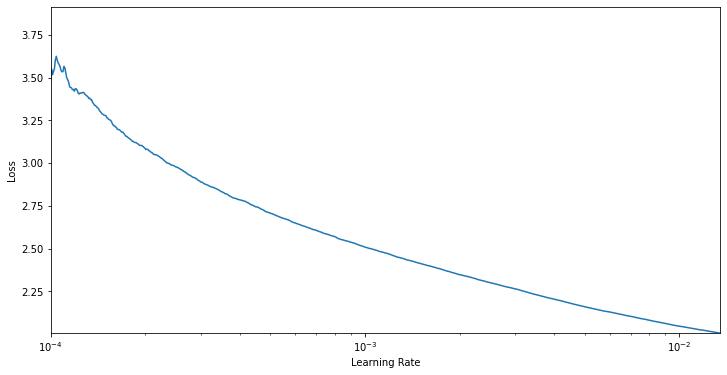

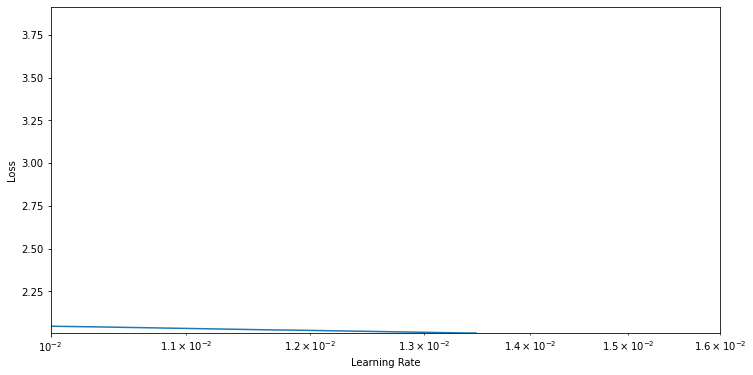

In [11]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


'''
For clarity we zoom into a chosen section of the x-axis
'''
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.01, 0.016)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Optimal Learning Rate for NAdam
We see that the loss drops linearly as we increase the learning rate from 0.0001 and becomes zero at the learning rate 0.0135. Thus, we use 0.0135 as our optimal learning rate for NAdam.

## Experiment 1 (a): Batch Normalization (NAdam with Optimal Learning Rate)

In [12]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=0.0135)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_CNN_He_ELU_VarDrop_BN"
model_name_format = "CIFAR10_CNN_He_ELU_VarDrop_BN.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 64
t0 = time.time()
history_CNN_He_ELU_VarDrop_BN = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_CNN_He_ELU_VarDrop_BN_sec = t1-t0
duration_CNN_He_ELU_VarDrop_BN = convertTime(duration_CNN_He_ELU_VarDrop_BN_sec)
print("\nTraining Time: ", duration_CNN_He_ELU_VarDrop_BN)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 30s 42ms/step - loss: 1.3640 - accuracy: 0.5188 - val_loss: 1.6847 - val_accuracy: 0.4906
Epoch 2/100
704/704 [==============================] - 29s 41ms/step - loss: 0.9575 - accuracy: 0.6652 - val_loss: 2.8979 - val_accuracy: 0.2840
Epoch 3/100
704/704 [==============================] - 29s 42ms/step - loss: 0.8356 - accuracy: 0.7117 - val_loss: 1.4846 - val_accuracy: 0.5894
Epoch 4/100
704/704 [==============================] - 29s 41ms/step - loss: 0.7494 - accuracy: 0.7426 - val_loss: 0.9977 - val_accuracy: 0.6914
Epoch 5/100
704/704 [==============================] - 30s 42ms/step - loss: 0.6927 - accuracy: 0.7650 - val_loss: 0.7866 - val_accuracy: 0.7342
Epoch 6/100
704/704 [==============================] - 29s 42ms/step - loss: 0.6576 - accuracy: 0.7772 - val_loss: 0.8170 - val_accuracy: 0.7294
Epoch 7/100
704/704 [==============================] - 29s 41ms/step - loss: 0.6149 - accuracy: 0.7914 - val_loss: 0.9021 - val_ac

Epochs:  100

CIFAR10_CNN_He_ELU_VarDrop_BN Test Accuracy: 0.866
CIFAR10_CNN_He_ELU_VarDrop_BN Test Loss: 0.580

Test Confusion Matrix:
[[836  10  23  24  16   7  18  10  27  29]
 [  3 933   0   3   3   1   3   1   3  50]
 [ 32   0 764  31  46  46  62  13   3   3]
 [  6   1  23 719  34 125  73  14   0   5]
 [  3   0  23  12 897  23  22  20   0   0]
 [  1   1  18  79  22 834  21  19   1   4]
 [  3   0   6  12  13   4 958   3   0   1]
 [  5   0   7  21  36  34  12 883   0   2]
 [ 27  18   5  14   2   1  14   2 900  17]
 [  4  33   2   4   0   3   7   4   8 935]]


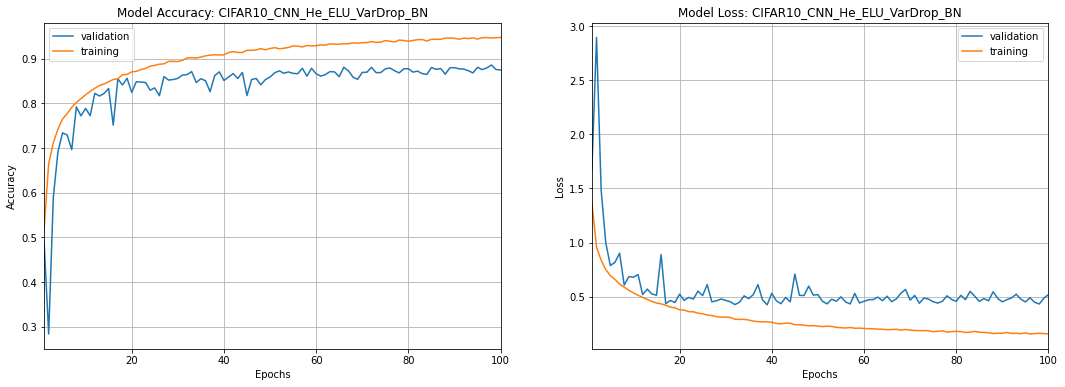

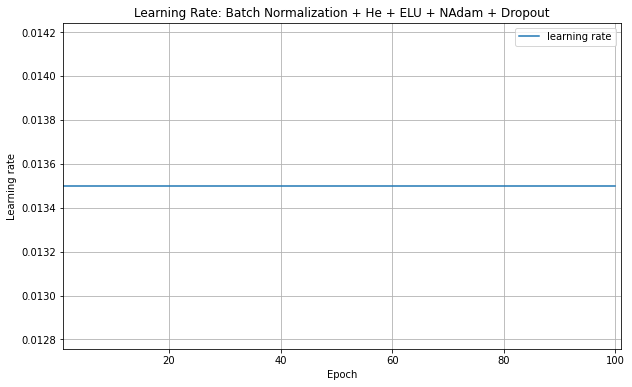

In [13]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_He_ELU_VarDropout_BN.h5")

numOfEpochs_CNN_He_ELU_VarDrop_BN = len(history_CNN_He_ELU_VarDrop_BN.history['loss'])
print("Epochs: ", numOfEpochs_CNN_He_ELU_VarDrop_BN)

test_loss_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_He_ELU_VarDrop_BN = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_He_ELU_VarDrop_BN))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_He_ELU_VarDrop_BN))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_He_ELU_VarDrop_BN, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_He_ELU_VarDrop_BN, 
                   "Learning Rate: Batch Normalization + He + ELU + NAdam + Dropout", momentumPlot=False)

## Expriment 1(b): Batch Normalization

Instead of using the NAdam optimizer we use 1cycle learning rate schedule with He initializer and ELU activation.


### Find Maximum Learning Rate for 1cycle Schedule

In [14]:

%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 22s 32ms/step - loss: 2.2991 - accuracy: 0.2972 - val_loss: 6.7923 - val_accuracy: 0.1542
CPU times: user 17.7 s, sys: 3.78 s, total: 21.5 s
Wall time: 24.6 s


## Learning rate vs Loss Plot

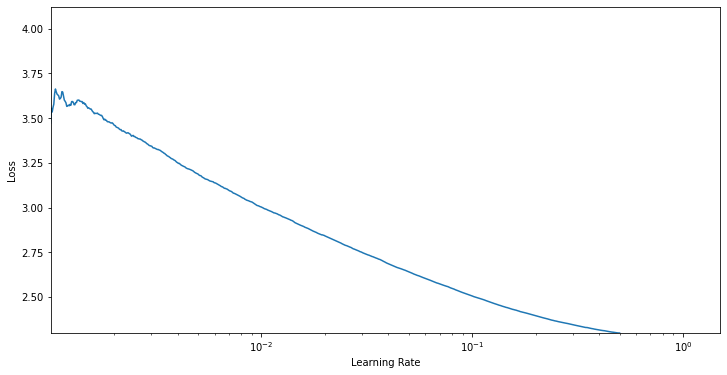

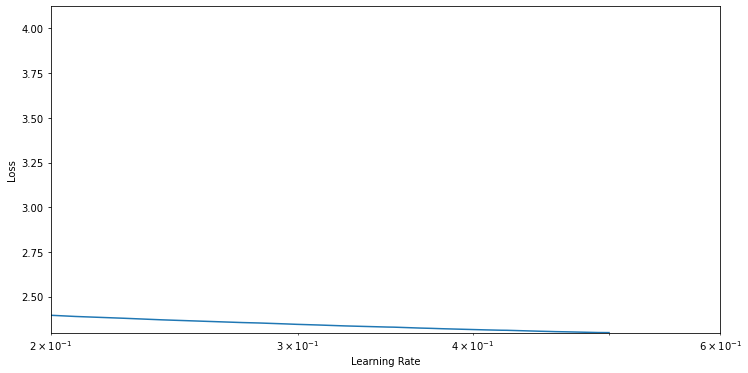

In [17]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1.5)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.2, 0.6)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Max Learning Rate for 1cycle Schedule

From the above plot we see that the max learning rate is 0.5 at which loss is minimum.

In [18]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_BN_1cycle"
model_name_format = "CIFAR10_CNN_BN_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.5, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_BN_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_BN_1cycle_sec = t1-t0
duration_CNN_BN_1cycle = convertTime(duration_CNN_BN_1cycle_sec)
print("\nTraining Time: ", duration_CNN_BN_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 23s 33ms/step - loss: 1.6221 - accuracy: 0.4255 - val_loss: 1.4653 - val_accuracy: 0.4772
Epoch 2/100
704/704 [==============================] - 23s 32ms/step - loss: 1.2338 - accuracy: 0.5528 - val_loss: 1.1380 - val_accuracy: 0.5768
Epoch 3/100
704/704 [==============================] - 23s 32ms/step - loss: 1.0803 - accuracy: 0.6148 - val_loss: 1.1891 - val_accuracy: 0.5852
Epoch 4/100
704/704 [==============================] - 23s 33ms/step - loss: 0.9827 - accuracy: 0.6514 - val_loss: 1.0579 - val_accuracy: 0.6296
Epoch 5/100
704/704 [==============================] - 23s 32ms/step - loss: 0.9019 - accuracy: 0.6809 - val_loss: 1.0794 - val_accuracy: 0.6488
Epoch 6/100
704/704 [==============================] - 23s 32ms/step - loss: 0.8493 - accuracy: 0.7012 - val_loss: 0.9021 - val_accuracy: 0.6788
Epoch 7/100
704/704 [==============================] - 23s 32ms/step - loss: 0.8020 - accuracy: 0.7197 - val_loss: 1.1021 - val_ac

Epochs:  100

CIFAR10_CNN_BN_1cycle Test Accuracy: 0.880
CIFAR10_CNN_BN_1cycle Test Loss: 0.498

Test Confusion Matrix:
[[898  11  14   7   4   1   9   5  37  14]
 [  5 950   0   1   3   2   2   0   5  32]
 [ 37   0 786  32  54  31  36  15   9   0]
 [  8   5  34 756  44 103  29   9   8   4]
 [  4   0  26  20 902   9  17  18   4   0]
 [  6   0  16  97  25 824  10  20   0   2]
 [  6   1  19  18  13  12 925   5   0   1]
 [ 10   1  10  19  33  19   1 903   2   2]
 [ 29   9   6   2   0   3   2   1 930  18]
 [ 10  40   3   5   1   1   3   2  12 923]]


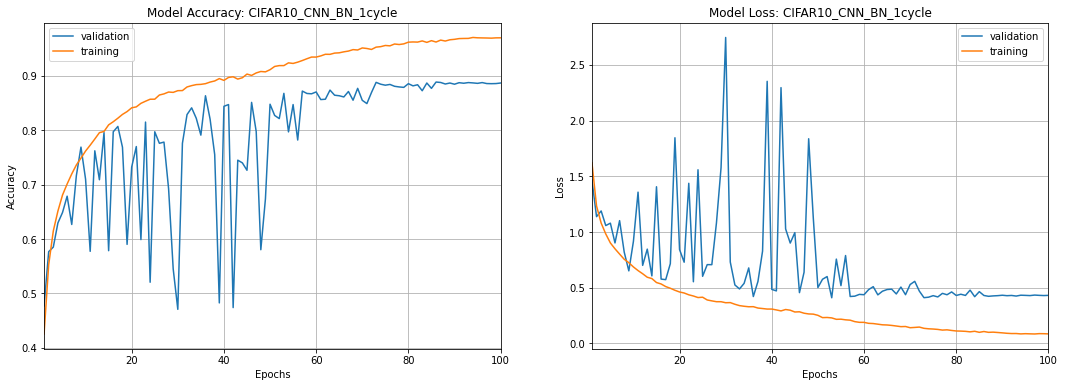

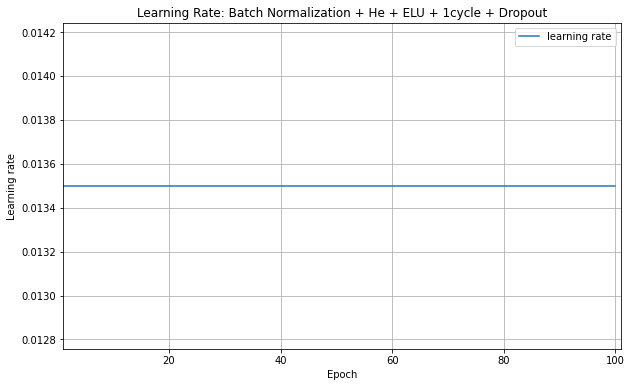

In [19]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_BN_1cycle.h5")

numOfEpochs_CNN_BN_1cycle = len(history_CNN_BN_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_BN_1cycle)

test_loss_CNN_BN_1cycle, test_accuracy_CNN_BN_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_BN_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_BN_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_BN_1cycle, numOfEpochs_CNN_BN_1cycle, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_BN_1cycle, 
                   "Learning Rate: Batch Normalization + He + ELU + 1cycle + Dropout", momentumPlot=False)

## Experiment 2: Pretraining based Weight Initialization


One way to initialize the weights of a CNN is to pretrain it using a small subset of the training data with fewer classes. Then, use those pretrained weights to fine-tune the network with full training data. 


In this experiment we initialize the weights of the CNN via pretraining. We use a small subset of the training data (20%) and a small fraction of the classes (30%) to train the CNN. From another experiment we determined that 30% class is optimal for pretraining a CNN on CIFAR10 (see notebook 4). Then, using the pretrained layers (except the last two hidden layers and the final layer) as initial weights, we train the CNN using full training data. There are two steps in this pretraining based initialization approach:

- Step 1: Initialize weights by pretraining using a smaller training data
- Step 2: Fine-tune the pretrained network using full training data

For the pretraining part, we use the orthogonal weight initializer and ELU activation function. The model is regularized by using increasing dropout rate in the 4 hidden layers: 0.2, 0.3, 0.4 and 0.5. We pretrain the model for 10 fixed epochs. Within 10 epochs the validation accuracy exceeds 95%.

We set the SGD learning rate using the 1cycle learning schedule. For this, first we find the maximum learning rate. Then, using the maximum learning rate for 1cycle schedule we pretrain the model.

For the fine-tuning, we use the weights of first 2 hidden layers of the pretrained model and add last two hidden layers as well as the output layer. These new layers are initialized using orthogonal weight initializer (in experiment 2(a)) along with ELU activation. We use the same maximum learning rate for 1cycle learning schedule to train the model for fixed 100 epochs.

In addition to this, we perform another experiment (2(b)) in which we keep the above setting unchanged except the orthogonal initializer is replaced by He initializer.

Thus, there are two pretraining based experiments:
- Experiment 2(a):  Pretraining based Weight Initialization with Orthogonal Initializer

- Experiment 2(b):  Pretraining based Weight Initialization with He Initializer



## Create Small Training & Validation Set

We randomly select 3 classes and 3000 samples from each classs. Thus, the total training samples are 9000, which is 20% of the training data.


In [20]:
'''
Create a smaller training subset
'''

# Randomly select 3 class labels
class_labels_random = np.random.choice(10, 3, replace=False)


labels_class_1 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        labels_class_1 +=1
        
        
X_train_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_train_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        X_train_class_1_all[j] = X_train[i]
        y_train_class_1_all[j] = y_train[i]
        j += 1
        

X_train_class_1 = np.zeros((3000, 32,32,3), 'float32')
y_train_class_1 = np.zeros((3000, 1), 'uint8')


# Randomly select 3000 samples
class_labels_random_1 = np.random.choice(labels_class_1, 3000, replace=False)



j = 0
for i in range(len(class_labels_random_1)):
    X_train_class_1[j] = X_train_class_1_all[class_labels_random_1[i]]
    y_train_class_1[j] = y_train_class_1_all[class_labels_random_1[i]]


print("Small Training Label: ", y_train_class_1[0])


labels_class_2 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        labels_class_2 +=1
        
        
X_train_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_train_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        X_train_class_2_all[j] = X_train[i]
        y_train_class_2_all[j] = y_train[i]
        j += 1
        

X_train_class_2 = np.zeros((3000, 32,32,3), 'float32')
y_train_class_2 = np.zeros((3000, 1), 'uint8')


# Randomly select 3000 samples
class_labels_random_2 = np.random.choice(labels_class_2, 3000, replace=False)


j = 0
for i in range(len(class_labels_random_2)):
    X_train_class_2[j] = X_train_class_2_all[class_labels_random_2[i]]
    y_train_class_2[j] = y_train_class_2_all[class_labels_random_2[i]]



print("Small Training Label: ", y_train_class_2[0])






labels_class_3 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[2]):
        labels_class_3 +=1
        
        
X_train_class_3_all = np.zeros((labels_class_3, 32,32,3), 'float32')
y_train_class_3_all = np.zeros((labels_class_3, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[2]):
        X_train_class_3_all[j] = X_train[i]
        y_train_class_3_all[j] = y_train[i]
        j += 1
        

X_train_class_3 = np.zeros((3000, 32,32,3), 'float32')
y_train_class_3 = np.zeros((3000, 1), 'uint8')


# Randomly select 3000 samples
class_labels_random_3 = np.random.choice(labels_class_3, 3000, replace=False)


j = 0
for i in range(len(class_labels_random_3)):
    X_train_class_3[j] = X_train_class_3_all[class_labels_random_3[i]]
    y_train_class_3[j] = y_train_class_3_all[class_labels_random_3[i]]


print("Small Training Label: ", y_train_class_3[0])





X_train_small = np.concatenate((X_train_class_1, X_train_class_2, X_train_class_3), axis=0)
y_train_small = np.concatenate((y_train_class_1, y_train_class_2, y_train_class_3), axis=0)

print("\nShape of Small Training Samples: ", X_train_small.shape)
print("Shape of Small Training Labels: ", y_train_small.shape)

Small Training Label:  [8]
Small Training Label:  [1]
Small Training Label:  [5]

Shape of Small Training Samples:  (9000, 32, 32, 3)
Shape of Small Training Labels:  (9000, 1)


In [21]:
'''
Create a smaller validation subset
'''

# variable to store the number of samples in a selected class
labels_class_1 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        labels_class_1 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_valid_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        X_valid_class_1_all[j] = X_valid[i]
        y_valid_class_1_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_1 = np.zeros((300, 32,32,3), 'float32')
y_valid_class_1 = np.zeros((300, 1), 'uint8')


# Randomly select 300 samples
class_labels_random_1 = np.random.choice(labels_class_1, 300, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_1)):
    X_valid_class_1[j] = X_valid_class_1_all[class_labels_random_1[i]]
    y_valid_class_1[j] = y_valid_class_1_all[class_labels_random_1[i]]


        
print("Small Training Label: ", y_valid_class_1[0])


# variable to store the number of samples in a selected class
labels_class_2 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        labels_class_2 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_valid_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        X_valid_class_2_all[j] = X_valid[i]
        y_valid_class_2_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_2 = np.zeros((300, 32,32,3), 'float32')
y_valid_class_2 = np.zeros((300, 1), 'uint8')


# Randomly select 300 samples
class_labels_random_2 = np.random.choice(labels_class_2, 300, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_2)):
    X_valid_class_2[j] = X_valid_class_2_all[class_labels_random_2[i]]
    y_valid_class_2[j] = y_valid_class_2_all[class_labels_random_2[i]]


               
print("Small Training Label: ", y_valid_class_2[0])


# variable to store the number of samples in a selected class
labels_class_3 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[2]):
        labels_class_3 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_3_all = np.zeros((labels_class_3, 32,32,3), 'float32')
y_valid_class_3_all = np.zeros((labels_class_3, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[2]):
        X_valid_class_3_all[j] = X_valid[i]
        y_valid_class_3_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_3 = np.zeros((300, 32,32,3), 'float32')
y_valid_class_3 = np.zeros((300, 1), 'uint8')


# Randomly select 300 samples
class_labels_random_3 = np.random.choice(labels_class_3, 300, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_3)):
    X_valid_class_3[j] = X_valid_class_3_all[class_labels_random_3[i]]
    y_valid_class_3[j] = y_valid_class_3_all[class_labels_random_3[i]]


print("Small Training Label: ", y_valid_class_3[0])

X_valid_small = np.concatenate((X_valid_class_1, X_valid_class_2, X_valid_class_3), axis=0)
y_valid_small = np.concatenate((y_valid_class_1, y_valid_class_2, y_valid_class_3), axis=0)

print("\nShape of Small Validation Samples: ", X_valid_small.shape)
print("Shape of Small Validation Labels: ", y_valid_small.shape)

Small Training Label:  [8]
Small Training Label:  [1]
Small Training Label:  [5]

Shape of Small Validation Samples:  (900, 32, 32, 3)
Shape of Small Validation Labels:  (900, 1)


## Experiment 2(a): Weight Initialization by Pretraining using Orthogonal Initializer


##### Find Maximum Learning Rate for 1cycle Schedule

In [22]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'

model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

141/141 [==============================] - 4s 30ms/step - loss: 0.4885 - accuracy: 0.9994 - val_loss: 0.0160 - val_accuracy: 0.9967
CPU times: user 3.99 s, sys: 728 ms, total: 4.72 s
Wall time: 5.19 s


## Pretraining: Loss vs Learning Rate Plot

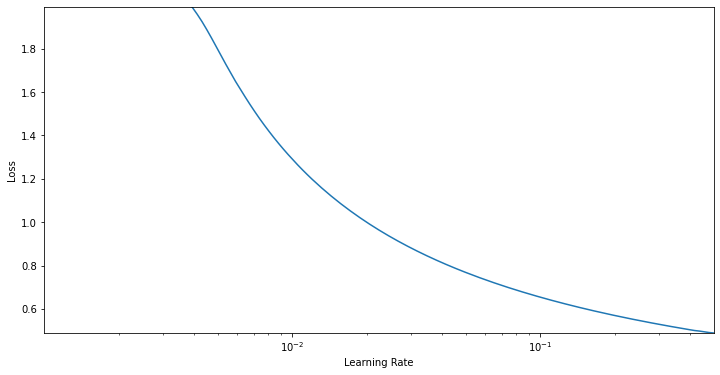

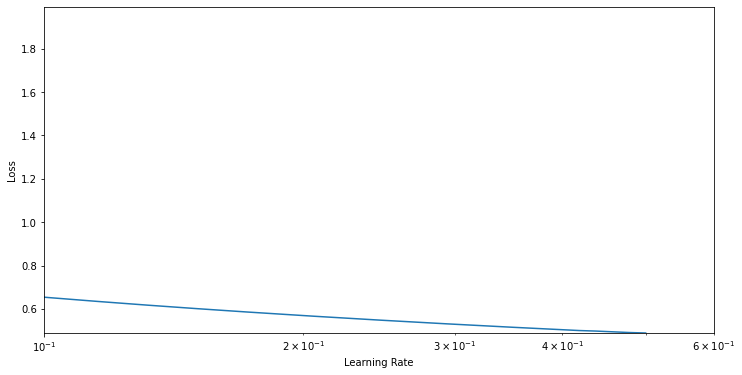

In [27]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.1, 0.6)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## 1cycle Max Learning Rate

We see from the above plot that loss becomes zero at 0.5 learning rate. However, to avoid overshooting, we use 0.08 as the maximum learning rate for 1cycle schedule.



## Experiment 2(a) Weight Initialization by Pretraining (Orthogonal Initializer)

In [28]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

model_pretrained = Sequential()
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.2))

model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.3))

model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.4))

model_pretrained.add(Flatten())
model_pretrained.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained.add(Dropout(0.5))
model_pretrained.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Pretraining_1cycle_Orthogonal"
model_name_format = "CIFAR10_CNN_Pretraining_1cycle_Orthogonal.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_1cycle_Orthogonal = model_pretrained.fit(X_train_small, y_train_small, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_1cycle_Orthogonal_sec = t1-t0
duration_Pretraining_1cycle_Orthogonal = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_1cycle_Orthogonal)
print("\n")


model_pretrained.save(model_name_format)

Epoch 1/10
282/282 [==============================] - 6s 20ms/step - loss: 0.0735 - accuracy: 0.9997 - val_loss: 0.0082 - val_accuracy: 0.9967
Epoch 2/10
282/282 [==============================] - 5s 19ms/step - loss: 8.4193e-04 - accuracy: 0.9999 - val_loss: 0.0077 - val_accuracy: 0.9967
Epoch 3/10
282/282 [==============================] - 6s 20ms/step - loss: 7.7019e-04 - accuracy: 0.9998 - val_loss: 0.0066 - val_accuracy: 0.9978
Epoch 4/10
282/282 [==============================] - 5s 19ms/step - loss: 7.7212e-04 - accuracy: 0.9998 - val_loss: 0.0131 - val_accuracy: 0.9967
Epoch 5/10
282/282 [==============================] - 5s 19ms/step - loss: 6.7985e-04 - accuracy: 0.9998 - val_loss: 0.0072 - val_accuracy: 0.9978
Epoch 6/10
282/282 [==============================] - 5s 19ms/step - loss: 6.7232e-04 - accuracy: 0.9997 - val_loss: 0.0056 - val_accuracy: 0.9978
Epoch 7/10
282/282 [==============================] - 5s 19ms/step - loss: 6.4346e-04 - accuracy: 0.9997 - val_loss: 0.005

## Experiment 2(a): Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [29]:
#model_pretrained = keras.models.load_model("CIFAR10_CNN_Pretraining_1cycle_Orthogonal.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_Orthogonal = keras.models.clone_model(model_pretrained)
model_pretrained_clone_Orthogonal.set_weights(model_pretrained.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained.layers))

model_pretrained_clone_Orthogonal.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 2(a): Fine-Tune the Pretrained Model with Full Training Data

In [30]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_FineTuning_1cycle_Orthogonal"
model_name_format = "CIFAR10_CNN_FineTuning_1cycle_Orthogonal.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_FineTuning_1cycle_Orthogonal = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_FineTuning_1cycle_Orthogonal_sec = t1-t0
duration_CNN_FineTuning_1cycle_Orthogonal = convertTime(duration_CNN_FineTuning_1cycle_Orthogonal_sec)
print("\nTraining Time: ", duration_CNN_FineTuning_1cycle_Orthogonal)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 27ms/step - loss: 1.9598 - accuracy: 0.2830 - val_loss: 2.4509 - val_accuracy: 0.1784
Epoch 2/100
704/704 [==============================] - 19s 27ms/step - loss: 1.6457 - accuracy: 0.4039 - val_loss: 1.7831 - val_accuracy: 0.3686
Epoch 3/100
704/704 [==============================] - 19s 27ms/step - loss: 1.4648 - accuracy: 0.4702 - val_loss: 1.4184 - val_accuracy: 0.5100
Epoch 4/100
704/704 [==============================] - 19s 27ms/step - loss: 1.3348 - accuracy: 0.5248 - val_loss: 1.4227 - val_accuracy: 0.5016
Epoch 5/100
704/704 [==============================] - 19s 27ms/step - loss: 1.2221 - accuracy: 0.5659 - val_loss: 1.1566 - val_accuracy: 0.5956
Epoch 6/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1414 - accuracy: 0.5967 - val_loss: 1.1272 - val_accuracy: 0.6024
Epoch 7/100
704/704 [==============================] - 19s 27ms/step - loss: 1.0801 - accuracy: 0.6226 - val_loss: 2.1041 - val_ac

Epochs:  100

CIFAR10_CNN_FineTuning_1cycle_Orthogonal Test Accuracy: 0.871
CIFAR10_CNN_FineTuning_1cycle_Orthogonal Test Loss: 0.509

Test Confusion Matrix:
[[876   7  34  10   6   3   4   8  34  18]
 [  6 923   0   4   2   0   3   0  12  50]
 [ 36   1 809  31  39  30  35  11   6   2]
 [ 10   3  40 738  32 114  38  11   7   7]
 [  5   0  38  32 867  15  18  20   4   1]
 [  3   1  22 104  30 810   8  18   3   1]
 [  5   0  18  27  18  10 915   4   2   1]
 [  6   0  13  22  26  26   3 900   1   3]
 [ 30   5   3   4   0   4   1   3 932  18]
 [ 13  21   2   5   1   0   2   1  13 942]]


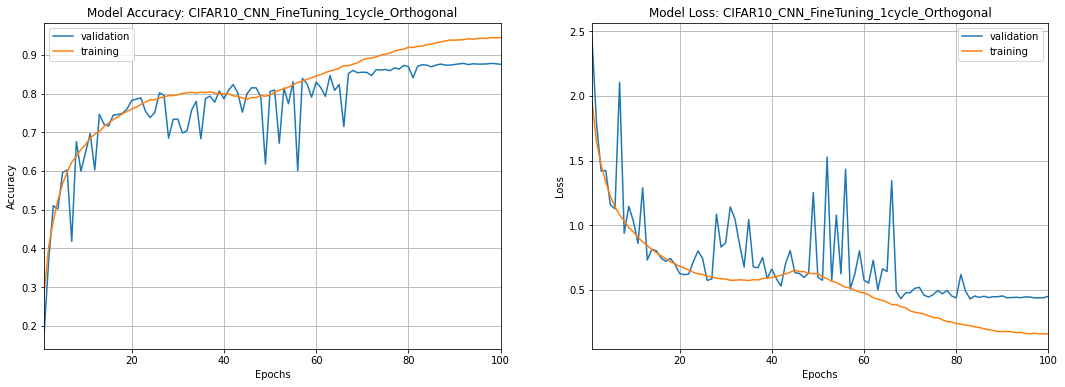

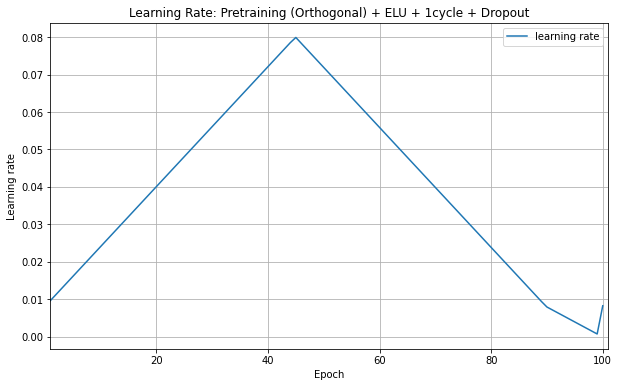

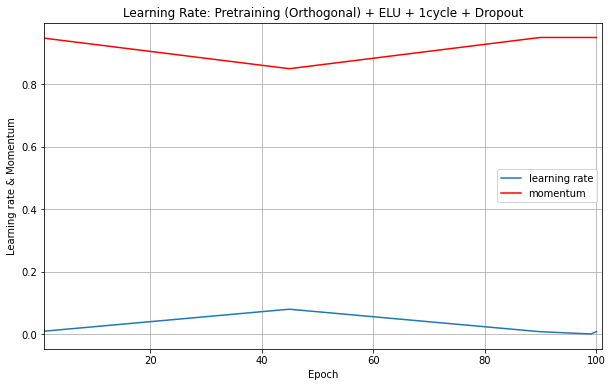

In [31]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_FineTuning_1cycle_Orthogonal.h5")

numOfEpochs_CNN_FineTuning_1cycle_Orthogonal = len(history_CNN_FineTuning_1cycle_Orthogonal.history['loss'])
print("Epochs: ", numOfEpochs_CNN_FineTuning_1cycle_Orthogonal)

test_loss_CNN_FineTuning_1cycle_Orthogonal, test_accuracy_CNN_FineTuning_1cycle_Orthogonal = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_FineTuning_1cycle_Orthogonal))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_FineTuning_1cycle_Orthogonal))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_FineTuning_1cycle_Orthogonal, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                   "Learning Rate: Pretraining (Orthogonal) + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                   "Learning Rate: Pretraining (Orthogonal) + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 2(b): Weight Initialization by Pretraining using He Initializer

#### Find Maximum Learning Rate for 1cycle Schedule

In [32]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

141/141 [==============================] - 4s 28ms/step - loss: 0.1742 - accuracy: 0.9879 - val_loss: 0.0276 - val_accuracy: 0.9967
CPU times: user 3.87 s, sys: 679 ms, total: 4.55 s
Wall time: 5.02 s


## Experiment 2(b): Loss vs Learning Rate Plot

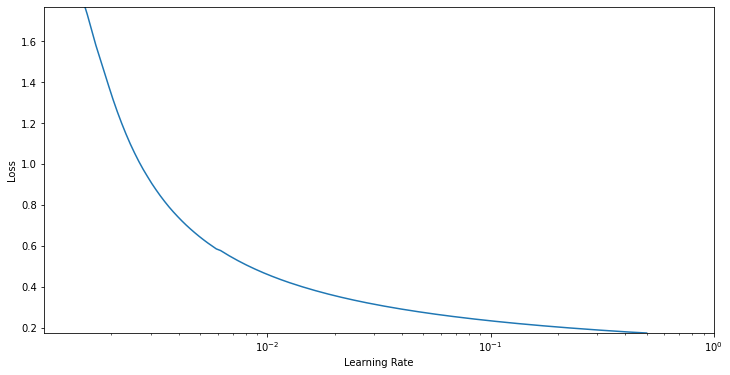

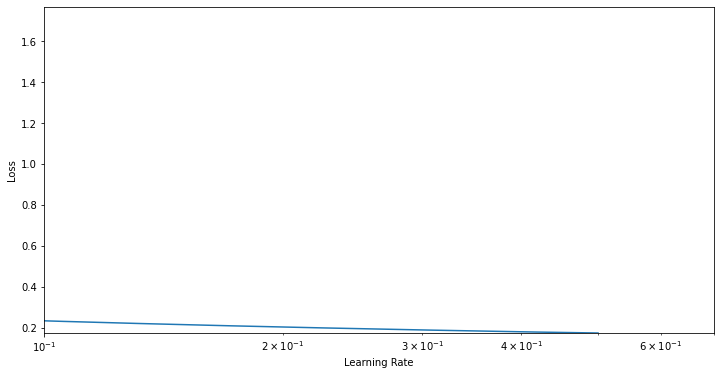

In [34]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.1, 0.7)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 2(b): 1cycle Max Learning Rate

We see from the above plot that loss becomes zero at 0.5 learning rate. However, to avoid overshooting, we use 0.08 as the maximum learning rate for 1cycle schedule.



## Experiment 2(b) Weight Initialization by Pretraining (He Initializer)

In [35]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'

model_pretrained_He = Sequential()
model_pretrained_He.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained_He.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.2))

model_pretrained_He.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.3))

model_pretrained_He.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.4))

model_pretrained_He.add(Flatten())
model_pretrained_He.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained_He.add(Dropout(0.5))
model_pretrained_He.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained_He.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Pretraining_1cycle_He"
model_name_format = "CIFAR10_CNN_Pretraining_1cycle_He.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_1cycle_He = model_pretrained_He.fit(X_train_small, y_train_small, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               early_stopping_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_1cycle_He_sec = t1-t0
duration_Pretraining_1cycle_He = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_1cycle_He)
print("\n")


model_pretrained_He.save(model_name_format)

Epoch 1/10
282/282 [==============================] - 6s 20ms/step - loss: 0.0240 - accuracy: 0.9976 - val_loss: 0.0086 - val_accuracy: 0.9967
Epoch 2/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.0172 - val_accuracy: 0.9978
Epoch 3/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 0.0095 - val_accuracy: 0.9978
Epoch 4/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0071 - accuracy: 0.9994 - val_loss: 0.0376 - val_accuracy: 0.9978
Epoch 5/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0065 - accuracy: 0.9997 - val_loss: 0.0282 - val_accuracy: 0.9967
Epoch 6/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0058 - val_accuracy: 0.9978
Epoch 7/10
282/282 [==============================] - 5s 19ms/step - loss: 2.5805e-04 - accuracy: 0.9999 - val_loss: 0.0052 - val_accuracy: 0.

## Experiment 2(b): Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [36]:
#model_pretrained = keras.models.load_model("CIFAR10_CNN_Pretraining_1cycle_He.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_He = keras.models.clone_model(model_pretrained_He)
model_pretrained_clone_He.set_weights(model_pretrained_He.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained_He.layers))

model_pretrained_clone_He.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained_He.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


initializer = 'he_normal'


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 2(b): Fine-Tune the Pretrained Model with Full Training Data

In [37]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_FineTuning_1cycle_He"
model_name_format = "CIFAR10_CNN_FineTuning_1cycle_He.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_FineTuning_1cycle_He = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_FineTuning_1cycle_He_sec = t1-t0
duration_CNN_FineTuning_1cycle_He = convertTime(duration_CNN_FineTuning_1cycle_He_sec)
print("\nTraining Time: ", duration_CNN_FineTuning_1cycle_He)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 28ms/step - loss: 2.0739 - accuracy: 0.2804 - val_loss: 2.3737 - val_accuracy: 0.2216
Epoch 2/100
704/704 [==============================] - 19s 27ms/step - loss: 1.6176 - accuracy: 0.4186 - val_loss: 1.6434 - val_accuracy: 0.4338
Epoch 3/100
704/704 [==============================] - 19s 27ms/step - loss: 1.4119 - accuracy: 0.4914 - val_loss: 1.3500 - val_accuracy: 0.5272
Epoch 4/100
704/704 [==============================] - 19s 27ms/step - loss: 1.2834 - accuracy: 0.5423 - val_loss: 1.5564 - val_accuracy: 0.4912
Epoch 5/100
704/704 [==============================] - 19s 28ms/step - loss: 1.1868 - accuracy: 0.5786 - val_loss: 1.3024 - val_accuracy: 0.5588
Epoch 6/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1210 - accuracy: 0.6026 - val_loss: 1.0898 - val_accuracy: 0.6238
Epoch 7/100
704/704 [==============================] - 19s 27ms/step - loss: 1.0727 - accuracy: 0.6210 - val_loss: 1.9273 - val_ac

Epochs:  100

CIFAR10_CNN_FineTuning_1cycle_He Test Accuracy: 0.870
CIFAR10_CNN_FineTuning_1cycle_He Test Loss: 0.497

Test Confusion Matrix:
[[886   7  28  10   4   3   7   8  31  16]
 [  6 926   2   5   2   2   4   2  12  39]
 [ 37   0 780  29  50  40  46  16   1   1]
 [ 10   1  35 745  40 105  47   9   5   3]
 [  5   1  23  29 888  15  23  13   3   0]
 [  3   0  17 128  25 796  11  17   0   3]
 [  3   0  18  26  11   8 929   2   2   1]
 [  4   0  10  25  31  28   5 895   1   1]
 [ 28   7   3   3   1   3   4   2 932  17]
 [ 14  32   2   9   1   1   2   7   9 923]]


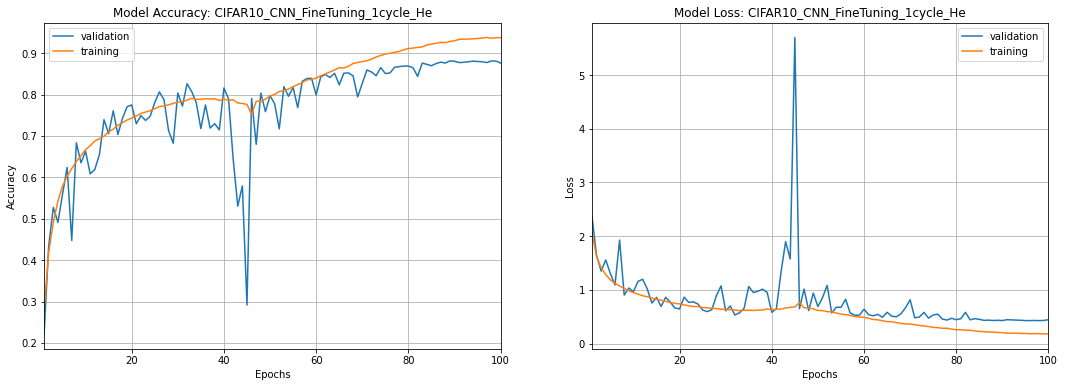

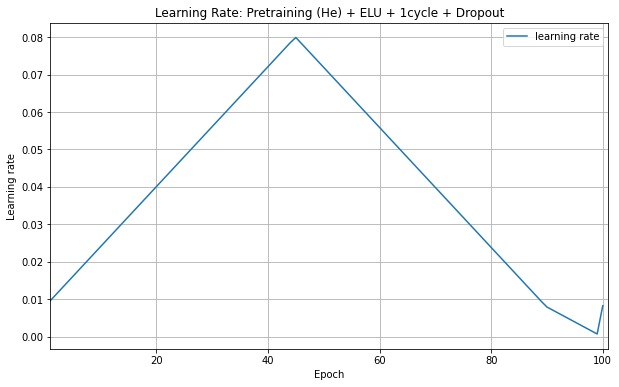

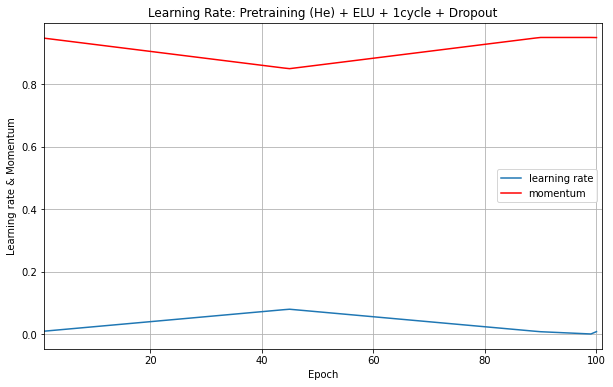

In [38]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_FineTuning_1cycle_He.h5")

numOfEpochs_CNN_FineTuning_1cycle_He = len(history_CNN_FineTuning_1cycle_He.history['loss'])
print("Epochs: ", numOfEpochs_CNN_FineTuning_1cycle_He)

test_loss_CNN_FineTuning_1cycle_He, test_accuracy_CNN_FineTuning_1cycle_He = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_FineTuning_1cycle_He))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_FineTuning_1cycle_He))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_FineTuning_1cycle_He, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_He, 
                   "Learning Rate: Pretraining (He) + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_He, 
                   "Learning Rate: Pretraining (He) + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 3 (a): Orthogonal Initializer + ELU Activation + 1cycle Learning Schedule

#### Find Maximum Learning Rate for 1cycle Schedule

In [39]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 19s 27ms/step - loss: nan - accuracy: 0.1801 - val_loss: nan - val_accuracy: 0.1010
CPU times: user 14.5 s, sys: 3.24 s, total: 17.7 s
Wall time: 20.2 s


## Experiment 3: Loss vs Learning Rate Plot

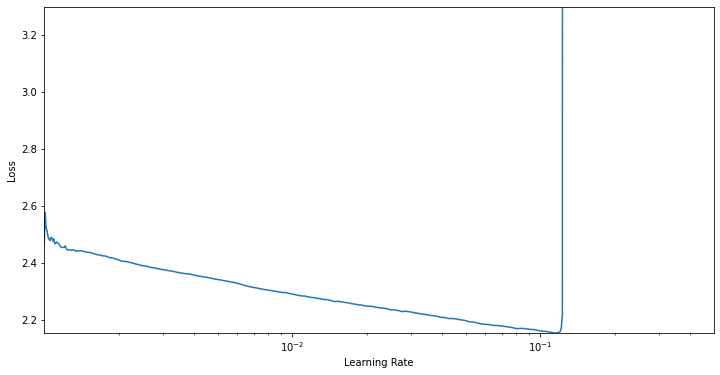

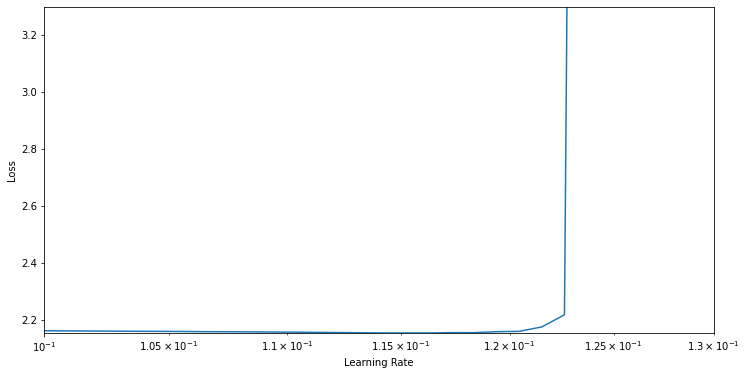

In [40]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
#plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.1, 0.13)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 3 (a): 1cycle Max Learning Rate
We see from the above plot that loss starts increasing after 0.12 learning rate. To avoid overshooting, We use 0.08 as the maximum learning rate for 1cycle schedule.

## Experiment 3 (a): Train the CNN using 1cycle Learning Schedule

In [41]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Orthogonal_1cycle"
model_name_format = "CIFAR10_CNN_Orthogonal_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_Orthogonal_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_Orthogonal_1cycle_sec = t1-t0
duration_CNN_Orthogonal_1cycle = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_Orthogonal_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 27ms/step - loss: 1.9552 - accuracy: 0.2803 - val_loss: 2.0632 - val_accuracy: 0.2622
Epoch 2/100
704/704 [==============================] - 19s 27ms/step - loss: 1.6557 - accuracy: 0.3973 - val_loss: 1.5505 - val_accuracy: 0.4250
Epoch 3/100
704/704 [==============================] - 19s 27ms/step - loss: 1.4788 - accuracy: 0.4656 - val_loss: 1.4540 - val_accuracy: 0.4870
Epoch 4/100
704/704 [==============================] - 19s 27ms/step - loss: 1.3388 - accuracy: 0.5212 - val_loss: 1.2679 - val_accuracy: 0.5500
Epoch 5/100
704/704 [==============================] - 19s 27ms/step - loss: 1.2219 - accuracy: 0.5645 - val_loss: 1.0459 - val_accuracy: 0.6390
Epoch 6/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1378 - accuracy: 0.6008 - val_loss: 1.0489 - val_accuracy: 0.6270
Epoch 7/100
704/704 [==============================] - 19s 27ms/step - loss: 1.0749 - accuracy: 0.6225 - val_loss: 2.9422 - val_ac

Epochs:  100

CIFAR10_CNN_Orthogonal_1cycle Test Accuracy: 0.870
CIFAR10_CNN_Orthogonal_1cycle Test Loss: 0.513

Test Confusion Matrix:
[[885   5  21   9   9   1   5  11  33  21]
 [  8 935   0   1   2   2   0   1  12  39]
 [ 40   0 788  42  36  28  42  18   5   1]
 [ 13   2  31 745  39  92  50  12   7   9]
 [  4   1  34  21 869  17  21  30   3   0]
 [  6   1  13 119  26 795  12  24   4   0]
 [  5   0  16  23  13  11 926   4   1   1]
 [  6   2  16  21  19  29   1 903   1   2]
 [ 37   5   4   6   2   3   2   0 932   9]
 [ 16  32   2   4   0   2   2   0  18 924]]


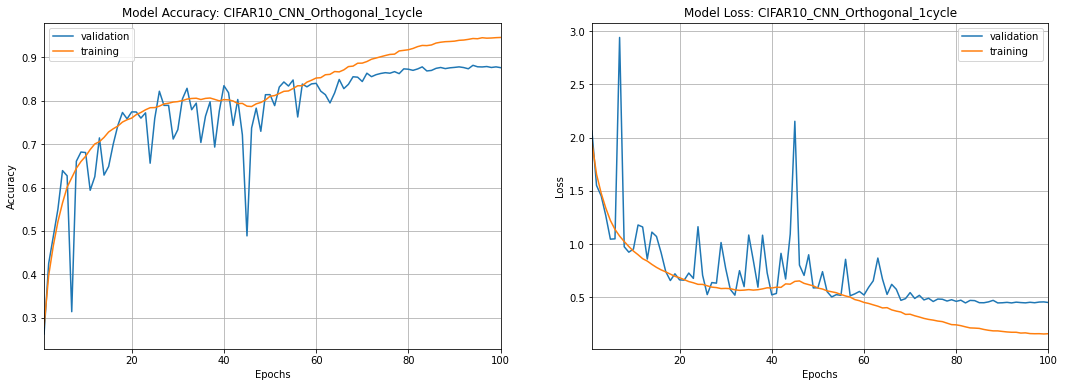

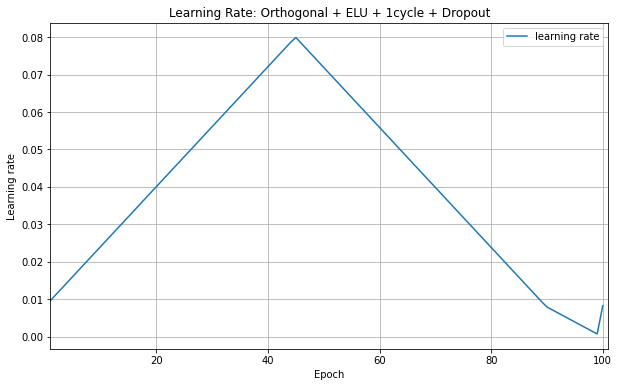

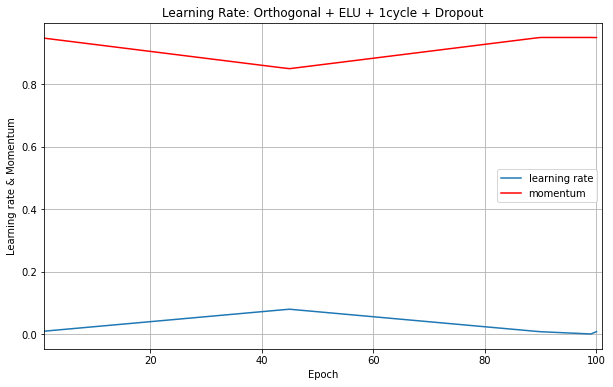

In [42]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_Orthogonal_1cycle.h5")

numOfEpochs_CNN_Orthogonal_1cycle = len(history_CNN_Orthogonal_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_Orthogonal_1cycle)

test_loss_CNN_Orthogonal_1cycle, test_accuracy_CNN_Orthogonal_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_Orthogonal_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_Orthogonal_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_Orthogonal_1cycle, numOfEpochs_CNN_Orthogonal_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 3(b): Orthogonal + ELU + NAdam 

In this experiment we **replace the 1cycle schedule** of the previous experiment with the NAdam optimizer.


First, we find the optimal learning rate for the NAdam optimizer.


### Heuristic to Find Optimal Constant Learning Rate

To find an optimal constant learing rate we train the network for one epoch and grow the learning rate at each iteration. Then, by observing the change in loss at each iteration we find the optimal learning rate.

To increase the learning rate by a constant factor we define the "IncreaseLearningRate" class.

### Finding an Optimal Constant Learning Rate for NAdam

First we create the CNN.

Then, we create an IncreaseLearningRate object. We use it to increase the learning rate by x% at each iteration. We pass this object as a callback to the fit() method of the model.

We start with a small learning rate of 0.0001, and grow it by 0.7% at each iteration. Then, using a loss vs. learning rate plot we find the optimal constant learning rate.


In [43]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))





'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by some factor (determined by 'computeFactorForIncreasingLearningRate' function)
We start with a small learning rate, and grow it by the factor at each iteration up to a large learning rate.
'''
size_mini_batch = 64
no_of_epochs = 1

increase_lr_cb = IncreaseLearningRate(factor=1.007)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 23s 33ms/step - loss: 36.2873 - accuracy: 0.2372 - val_loss: 2.3234 - val_accuracy: 0.1036
CPU times: user 19.1 s, sys: 4.1 s, total: 23.2 s
Wall time: 25.4 s


## Plot the Loss as a Function of the Learning Rate

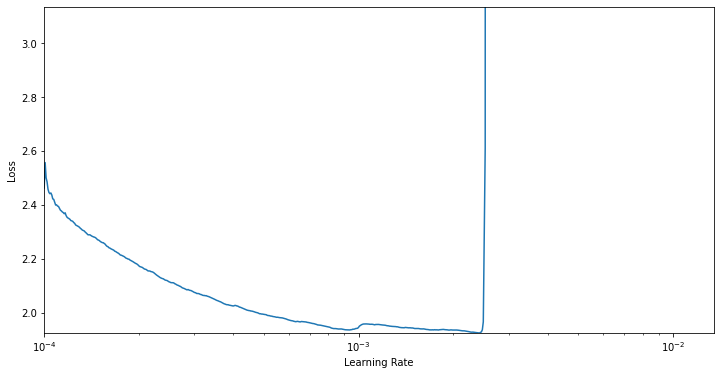

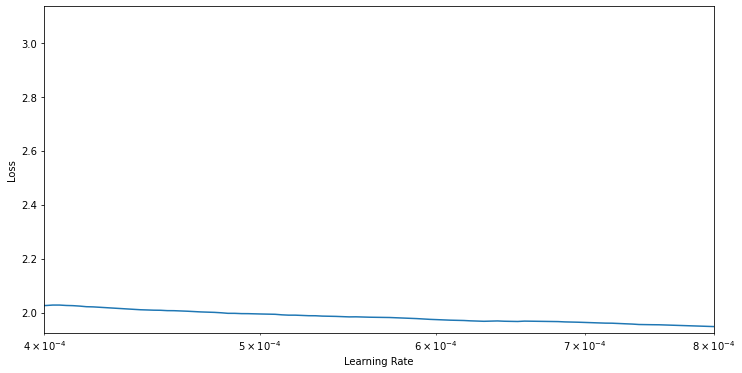

In [44]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


'''
For clarity we zoom into a chosen section of the x-axis
'''
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.0004, 0.0008)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Optimal Learning Rate for NAdam

We see that the loss starts increasing beyond the learning rate 0.002. Thus, we use 0.001 as our optimal learning rate.

## Experiment 3 (b): Orthogonal + ELU + NAdam with Optimal Learning Rate

In [45]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "CIFAR10_CNN_Orthogonal_Nadam"
model_name_format = "CIFAR10_CNN_Orthogonal_Nadam.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_CNN_Orthogonal_Nadam = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_CNN_Orthogonal_Nadam_sec = t1-t0
duration_CNN_Orthogonal_Nadam = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_Orthogonal_Nadam)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 23s 32ms/step - loss: 1.5372 - accuracy: 0.4534 - val_loss: 1.1600 - val_accuracy: 0.6086
Epoch 2/100
704/704 [==============================] - 22s 32ms/step - loss: 1.1521 - accuracy: 0.6000 - val_loss: 1.0118 - val_accuracy: 0.6490
Epoch 3/100
704/704 [==============================] - 22s 32ms/step - loss: 1.0285 - accuracy: 0.6410 - val_loss: 0.9892 - val_accuracy: 0.6516
Epoch 4/100
704/704 [==============================] - 23s 32ms/step - loss: 0.9609 - accuracy: 0.6636 - val_loss: 0.7972 - val_accuracy: 0.7198
Epoch 5/100
704/704 [==============================] - 22s 31ms/step - loss: 0.9091 - accuracy: 0.6819 - val_loss: 1.0432 - val_accuracy: 0.6406
Epoch 6/100
704/704 [==============================] - 22s 32ms/step - loss: 0.8846 - accuracy: 0.6946 - val_loss: 0.7119 - val_accuracy: 0.7524
Epoch 7/100
704/704 [==============================] - 22s 31ms/step - loss: 0.8510 - accuracy: 0.7057 - val_loss: 1.0413 - val_ac

Epochs:  100

CIFAR10_CNN_Orthogonal_Nadam Test Accuracy: 0.823
CIFAR10_CNN_Orthogonal_Nadam Test Loss: 0.606

Test Confusion Matrix:
[[812   7  44  39  11   2   5   9  45  26]
 [  3 905   0  21   0   0   3   4  20  44]
 [ 43   1 752  74  51  39  25   9   4   2]
 [ 18   2  39 713  25 143  31  14  12   3]
 [  8   1  34  61 798  37  22  35   4   0]
 [  3   0  31 157  15 762  10  18   2   2]
 [  7   2  23  65   9  11 871   2   9   1]
 [  6   0  30  59  22  57   3 823   0   0]
 [ 36  11  10  19   1   1   2   0 909  11]
 [ 21  35   3  29   1   0   2   5  19 885]]


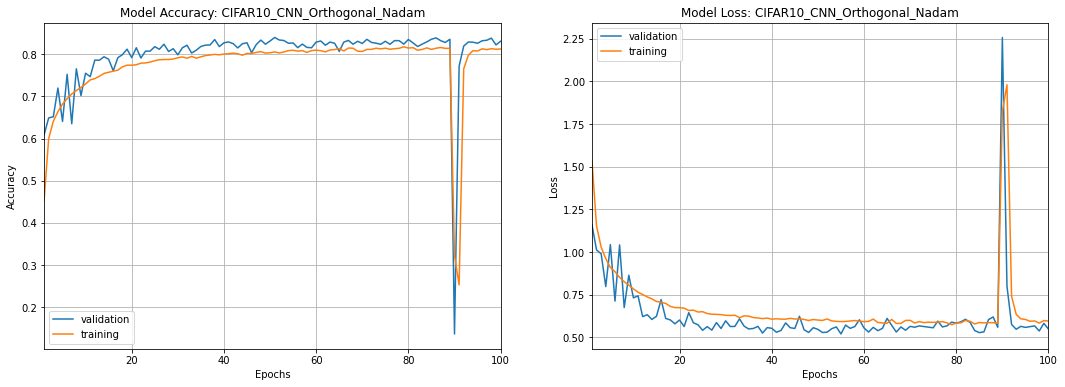

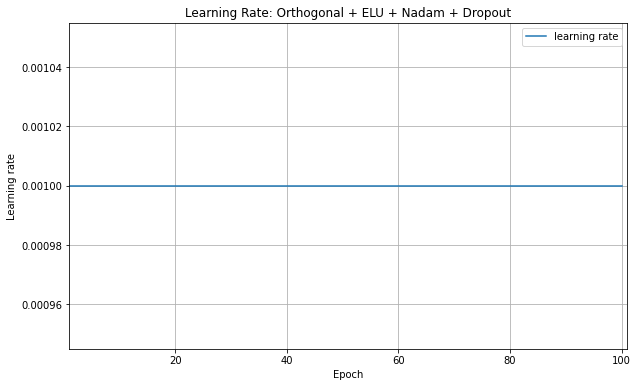

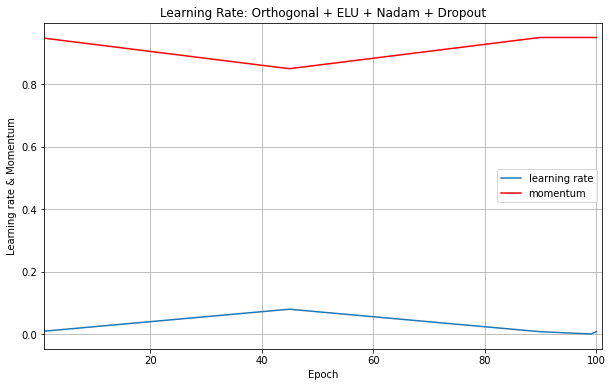

In [46]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_Orthogonal_Nadam.h5")

numOfEpochs_CNN_Orthogonal_Nadam = len(history_CNN_Orthogonal_Nadam.history['loss'])
print("Epochs: ", numOfEpochs_CNN_Orthogonal_1cycle)

test_loss_CNN_Orthogonal_Nadam, test_accuracy_CNN_Orthogonal_Nadam = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_Orthogonal_Nadam))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_Orthogonal_Nadam))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_Orthogonal_Nadam, numOfEpochs_CNN_Orthogonal_Nadam, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_Orthogonal_Nadam, 
                   "Learning Rate: Orthogonal + ELU + Nadam + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + Nadam + Dropout", momentumPlot=True)

## Experiment 4: He Initializer + ELU Activation + 1cycle Learning Schedule

#### Find Maximum Learning Rate for 1cycle Schedule

In [47]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 19s 26ms/step - loss: nan - accuracy: 0.1634 - val_loss: nan - val_accuracy: 0.1010
CPU times: user 13.7 s, sys: 3.22 s, total: 16.9 s
Wall time: 19.7 s


## Experiment 4: Loss vs Learning Rate Plot

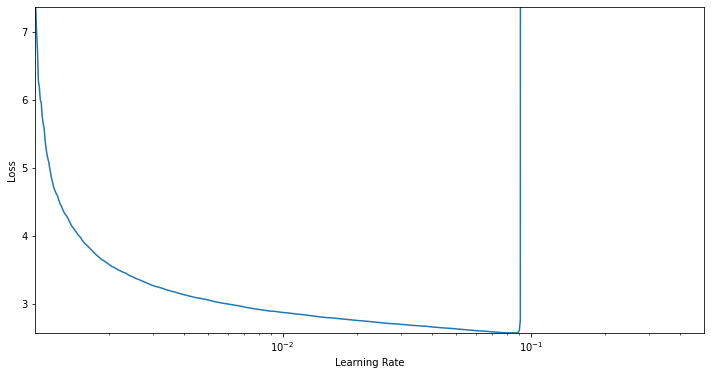

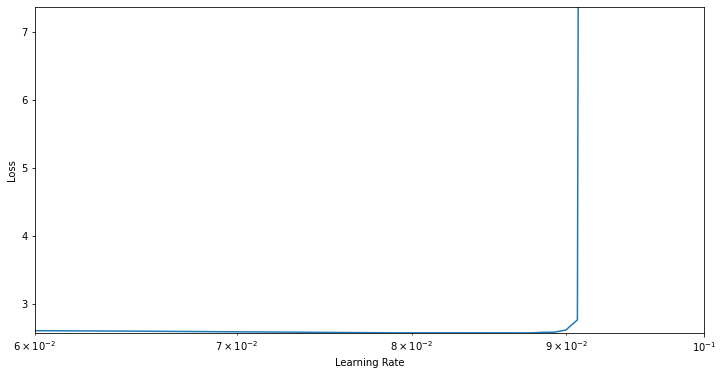

In [49]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

'''
For clarity we zoom in to a smaller range
'''

plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.06, 0.1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 4: 1cycle Max Learning Rate
We see from the above plot that loss starts increasing after 0.09 learning rate. Thus, we use 0.08 as the maximum learning rate for 1cycle schedule.


## Experiment 4: Train the CNN using 1cycle Learning Schedule

In [50]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_He_1cycle"
model_name_format = "CIFAR10_CNN_He_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_He_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_He_1cycle_sec = t1-t0
duration_CNN_He_1cycle = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_He_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 27ms/step - loss: 2.1048 - accuracy: 0.2750 - val_loss: 2.4974 - val_accuracy: 0.2248
Epoch 2/100
704/704 [==============================] - 19s 27ms/step - loss: 1.6306 - accuracy: 0.4110 - val_loss: 1.4365 - val_accuracy: 0.4742
Epoch 3/100
704/704 [==============================] - 19s 27ms/step - loss: 1.4124 - accuracy: 0.4897 - val_loss: 1.3076 - val_accuracy: 0.5454
Epoch 4/100
704/704 [==============================] - 19s 26ms/step - loss: 1.2773 - accuracy: 0.5392 - val_loss: 1.3831 - val_accuracy: 0.5266
Epoch 5/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1851 - accuracy: 0.5756 - val_loss: 1.3247 - val_accuracy: 0.5572
Epoch 6/100
704/704 [==============================] - 18s 26ms/step - loss: 1.1190 - accuracy: 0.6023 - val_loss: 0.9672 - val_accuracy: 0.6522
Epoch 7/100
704/704 [==============================] - 18s 26ms/step - loss: 1.0717 - accuracy: 0.6198 - val_loss: 2.7030 - val_ac

Epochs:  100

CIFAR10_CNN_He_1cycle Test Accuracy: 0.867
CIFAR10_CNN_He_1cycle Test Loss: 0.518

Test Confusion Matrix:
[[878  11  20  11  12   3   5   7  28  25]
 [  7 927   1   1   2   2   4   0  11  45]
 [ 42   1 783  26  42  36  49  14   3   4]
 [  6   0  32 727  46 102  54  18   6   9]
 [  4   0  25  23 886  15  22  19   5   1]
 [  4   1  24 111  26 798  12  21   2   1]
 [  3   1  13  31  13   6 930   1   1   1]
 [  8   2   6  28  34  38   5 877   0   2]
 [ 27  10   4   5   2   2   5   1 926  18]
 [ 11  27   2   6   1   0   3   4   7 939]]


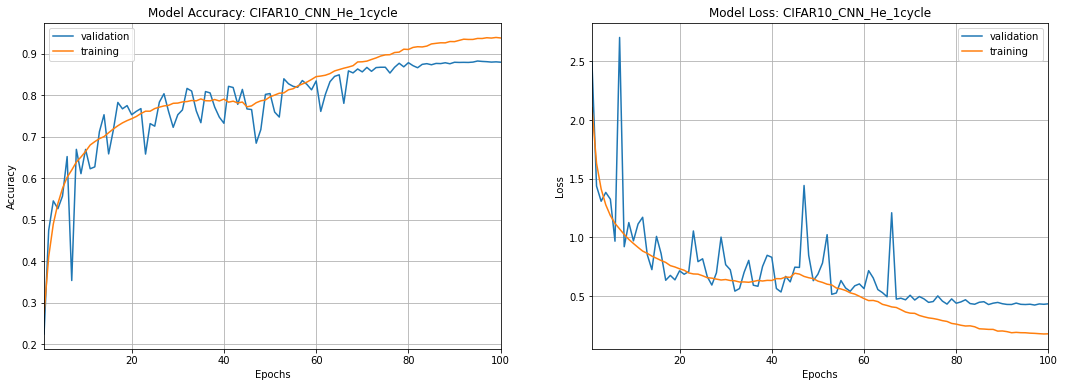

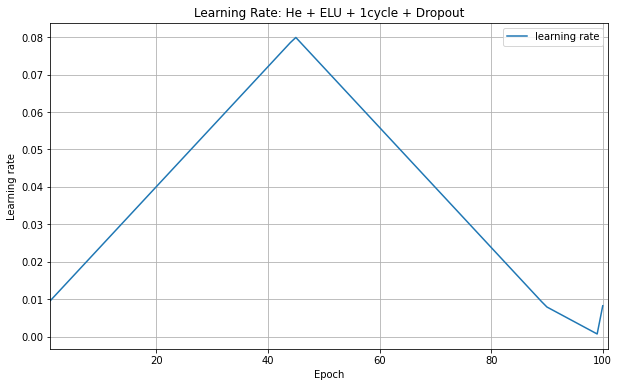

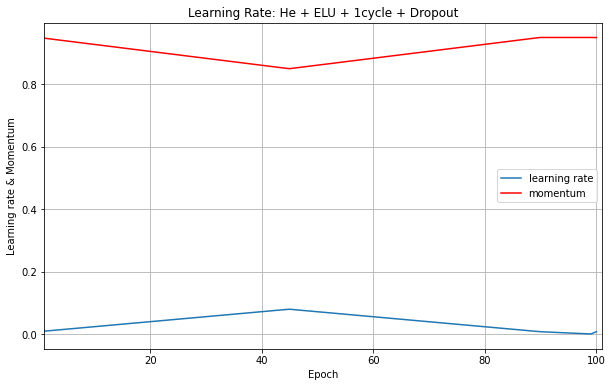

In [51]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_He_1cycle.h5")

numOfEpochs_CNN_He_1cycle = len(history_CNN_He_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_He_1cycle)

test_loss_CNN_He_1cycle, test_accuracy_CNN_He_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_He_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_He_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_He_1cycle, numOfEpochs_CNN_He_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_He_1cycle, 
                   "Learning Rate: He + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_He_1cycle, 
                   "Learning Rate: He + ELU + 1cycle + Dropout", momentumPlot=True)

## Comparison of Validation Accuracy Over Epochs

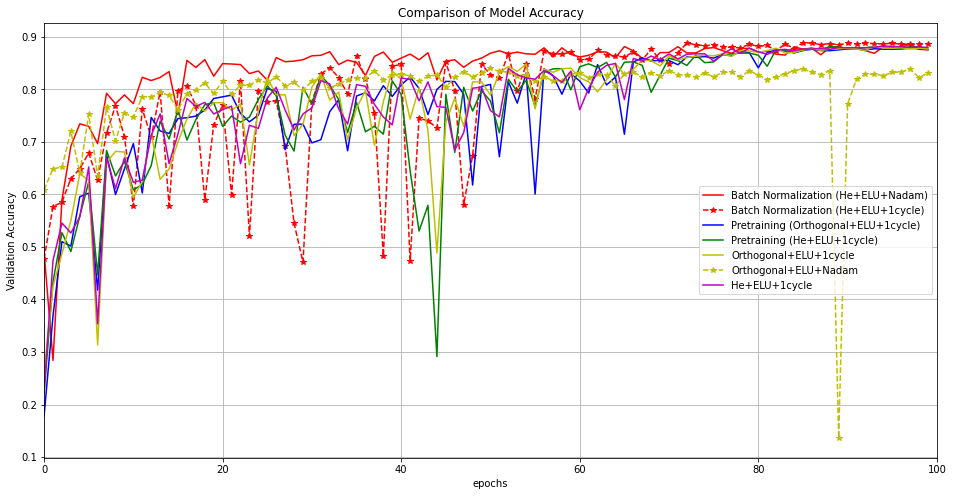

In [52]:
epochs = max(numOfEpochs_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal,
             numOfEpochs_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_Orthogonal_1cycle,
             numOfEpochs_CNN_He_1cycle)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_CNN_He_ELU_VarDrop_BN),history_CNN_He_ELU_VarDrop_BN.history['val_accuracy'],'r-',
         label='Batch Normalization (He+ELU+Nadam)')


plt.plot(range(numOfEpochs_CNN_BN_1cycle),history_CNN_BN_1cycle.history['val_accuracy'],'r*--',
         label='Batch Normalization (He+ELU+1cycle)')



plt.plot(range(numOfEpochs_CNN_FineTuning_1cycle_Orthogonal),history_CNN_FineTuning_1cycle_Orthogonal.history['val_accuracy'],'b-',
         label='Pretraining (Orthogonal+ELU+1cycle)')

plt.plot(range(numOfEpochs_CNN_FineTuning_1cycle_He),history_CNN_FineTuning_1cycle_He.history['val_accuracy'],'g-',
         label='Pretraining (He+ELU+1cycle)')

plt.plot(range(numOfEpochs_CNN_Orthogonal_1cycle),history_CNN_Orthogonal_1cycle.history['val_accuracy'],'y-',
         label='Orthogonal+ELU+1cycle')

plt.plot(range(numOfEpochs_CNN_Orthogonal_Nadam),history_CNN_Orthogonal_Nadam.history['val_accuracy'],'y*--',
         label='Orthogonal+ELU+Nadam')

plt.plot(range(numOfEpochs_CNN_He_1cycle),history_CNN_He_1cycle.history['val_accuracy'],'m-',
         label='He+ELU+1cycle')



plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()


## Comparison of Test Accuracy and Total Number of Epochs

In [56]:
data = [
    ["1(a): Batch Normalization (Nadam)", numOfEpochs_CNN_He_ELU_VarDrop_BN, duration_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_He_ELU_VarDrop_BN],
    ["1(b): Batch Normalization (1cycle)", numOfEpochs_CNN_BN_1cycle, duration_CNN_BN_1cycle, test_accuracy_CNN_BN_1cycle],
    ["2(a): Pretraining (Orthogonal)", numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, duration_CNN_FineTuning_1cycle_Orthogonal, 
     test_accuracy_CNN_FineTuning_1cycle_Orthogonal],
    ["2(b): Pretraining (He)", numOfEpochs_CNN_FineTuning_1cycle_He, duration_CNN_FineTuning_1cycle_He, 
     test_accuracy_CNN_FineTuning_1cycle_He],
    ["3(a): Orthogonal+ELU+1cycle", numOfEpochs_CNN_Orthogonal_1cycle, duration_CNN_Orthogonal_1cycle, 
     test_accuracy_CNN_Orthogonal_1cycle],
    ["3(b): Orthogonal+ELU+Nadam", numOfEpochs_CNN_Orthogonal_Nadam, duration_CNN_Orthogonal_Nadam, 
     test_accuracy_CNN_Orthogonal_Nadam],
    ["4: He+ELU+1cycle", numOfEpochs_CNN_He_1cycle, duration_CNN_He_1cycle, 
     test_accuracy_CNN_He_1cycle]]
pd.DataFrame(data, columns=["Experiments", "Epochs", "Training (Wall) Time", "Test Accuracy"])

,Experiments,Epochs,Training (Wall) Time,Test Accuracy
0,1(a): Batch Normalization (Nadam),100,48 min 37 s,0.8659
1,1(b): Batch Normalization (1cycle),100,38 min 16 s,0.8797
2,2(a): Pretraining (Orthogonal),100,31 min 41 s,0.8712
3,2(b): Pretraining (He),100,31 min 44 s,0.8700
4,3(a): Orthogonal+ELU+1cycle,100,31 min 43 s,0.8702
5,3(b): Orthogonal+ELU+Nadam,100,37 min 2 s,0.8230
6,4: He+ELU+1cycle,100,30 min 59 s,0.8671


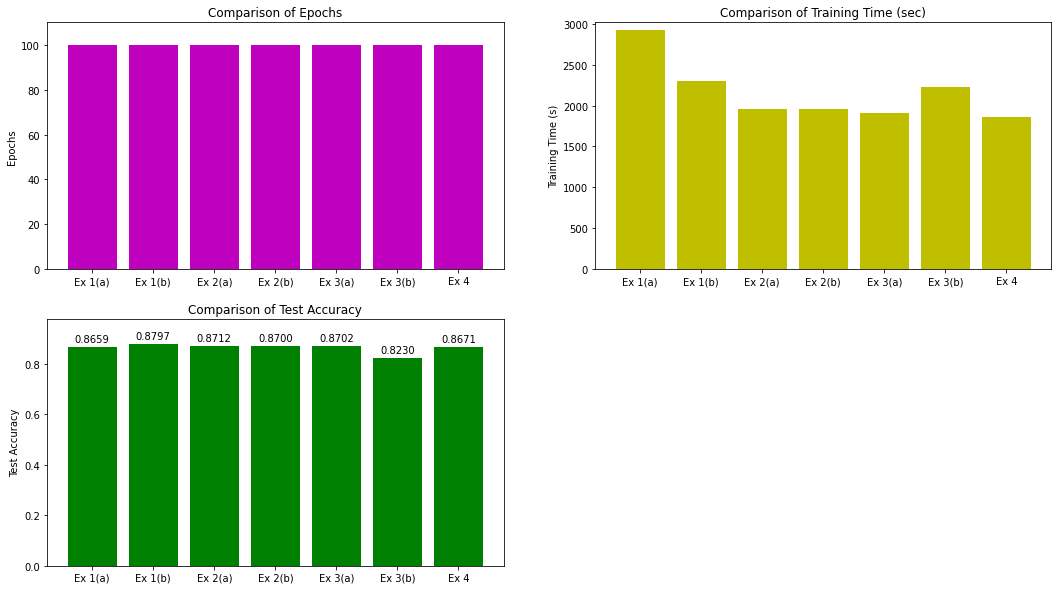

In [55]:
plt.figure(figsize=(18,10))

labels_true = ["Batch Normalization", "Pretraining (Orthogonal)", "Pretraining (He)", 
               "Orthogonal+ELU+1cycle", "He+ELU+1cycle"]


labels = ["Ex 1(a)", "Ex 1(b)", "Ex 2(a)", "Ex 2(b)", "Ex 3(a)", "Ex 3(b)", "Ex 4"]

epochs_num= [numOfEpochs_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_BN_1cycle, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal,
             numOfEpochs_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_Orthogonal_1cycle,
             numOfEpochs_CNN_Orthogonal_Nadam, numOfEpochs_CNN_He_1cycle]

duration_num = [duration_CNN_He_ELU_VarDrop_BN_sec, duration_CNN_BN_1cycle_sec,
                (duration_Pretraining_1cycle_Orthogonal_sec+duration_CNN_FineTuning_1cycle_Orthogonal_sec),
                (duration_Pretraining_1cycle_He_sec+duration_CNN_FineTuning_1cycle_He_sec),
                duration_CNN_Orthogonal_1cycle_sec, duration_CNN_Orthogonal_Nadam_sec, duration_CNN_He_1cycle_sec]

test_acc = [test_accuracy_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_BN_1cycle, test_accuracy_CNN_FineTuning_1cycle_Orthogonal,
            test_accuracy_CNN_FineTuning_1cycle_He, test_accuracy_CNN_Orthogonal_1cycle,
            test_accuracy_CNN_Orthogonal_Nadam, test_accuracy_CNN_He_1cycle]


plt.subplot(221)
plt.ylabel("Epochs")
plt.title("Comparison of Epochs")
plt.ylim(0, max(epochs_num)+10)
rects1=plt.bar(labels, epochs_num, color="m")

plt.subplot(222)
plt.ylabel("Training Time (s)")
plt.title("Comparison of Training Time (sec)")
plt.ylim(0, max(duration_num)+100)
rects2=plt.bar(labels, duration_num, color="y")

plt.subplot(223)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy")
plt.ylim(0, max(test_acc)+0.1)
rects3=plt.bar(labels, test_acc, color="g")

     
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects3)

plt.show()

## Comparative Analysis


Below we compare the performance of 4 approaches (with their variants) based on the results obtained from the following experiments:


- Experiment 1: Batch Normalization 
 
         -- a) He initializer + ELU activation + NAdam
         -- b) He initializer + ELU activation + 1cycle Learning Schedule

- Experiment 2: Pretraining based Weight Initialization with 1cycle Learning Schedule
 
         -- a) Orthogonal Initializer 
         -- b) He Initializer

- Experiment 3: Orthogonal Initializer + ELU activation

      -- a) 1cycle Learning Schedule
      -- b) NAdam 

- Experiment 4: He Initializer + ELU activation + 1cycle Learning Schedule

We observe that overall all approaches are equally effective. The test accuracy ranges between 0.86 ~ 0.87. However, their efficiency varies.

The **Batch Normalization** based approach has the highest test accuracy, but it converges slowly due to larger training time per epoch. Using 1cycle learning schedule it can converge faster (experiment 1b). But still its training time is never smaller than that of other approaches.

The most efficient approach is the **pretraining weight initialization** approach (2a and 2b). It requires shortest training time to achieve optimal test accuracy. We notice the the pretraining based approach performs slightly poorly when it is used with the He initializer (experimet 2b).

Both the **Orthogonal initializer** and the **He initializer** with 1cycle learning schedule (experiment 3a and 4) achieve high test accuracy (effective). Also both are faster than the Batch Normalization based approach.




Based on the experiments we make following remarks:
- The BN based approach is not necessarily the best approach to train a CNN. We should carefully consider its increased training time to trade-off for higher test accuracy, which is achievable via other methods such as pretraining initializer.  

- If one must use BN then it should be used with 1cycle learning schedule and fixed epochs.

- If efficiency is more important (by ensuring high test accuracy), then pretraining based initializer should be used.

- In the pretraining based approach the orthogonal initializer (2a) performs better as compared to He initializer (2b). Thus, the Orthogonal initializer should be used during pretraining and fine-tuning (for the added layers).

- The 1cycle learning rate schedule expedites convergence as compared to the NAdam fast optimizer. With NAdam we must know the optimal initial learning rate. A model's performance is sensitive to the initial choice of this learning rate. Finding the optimal learning rate for NAdam is expensive.

- The 1cycle learning schedule also increases the test accuracy (experiment 1b and 3a). In a separate notebook (notebook 3) we varied the NAdam learning rate for experiment 3b (Orthogonal initializer + ELU + Increasing Dropout) and observed that even the optimal learning rate does not achieve test accuracy larger than that obtained using 1cycle schedule.

- Finally, in all experiments we used a fixed number of epochs to train the CNNs. We also experimented with early stopping (not reported) and observed that it stopped training prematurely. We don't think early stopping is always effective. Depending on the problem we may need to train a network without early stopping. 


Finally, we find that the following choices for the three factors bring optimal performance in training CNNs.

- Weight initializer: orthogonal & pretraining
- Activation: ELU
- SGD learning rate: 1cycle 

Our observations are based on a simple CNN architecture with only 4 hidden layers. It would be useful to see how our prescribed optimal choices for the three factors pan out in sophisticated and heavy DNN architectures. 